# Part 4: Modeling
After meticulous feature engineering and visualization analysis, we now embark on the core phase of our project: Modeling

In this segment, we will apply various machine learning algorithms to predict `log_bike_count`, our target variable

We aim to develop and fine-tune models that accurately capture the intricate patterns observed in our data. Our focus will be on selecting the right models, optimizing their parameters, and evaluating their performance through rigorous testing.

This stage is crucial as it transforms our data insights and hypotheses into concrete, predictive tools, enabling us to forecast bike traffic trends in Paris effectively

In [1]:
# installs
#!pip install lightgbm

In [2]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Linear Regression
from sklearn.linear_model import LinearRegression

# Ridge Regression
from sklearn.linear_model import Ridge

# Lasso Regression
from sklearn.linear_model import Lasso

# K-Nearest Neighbors (KNN) Regression
from sklearn.neighbors import KNeighborsRegressor

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# XGBoost Regression
from xgboost import XGBRegressor

# CatBoost Regression
from catboost import CatBoostRegressor

# LightGBM Regression
from lightgbm import LGBMRegressor

## Loading the processed data

In [3]:
# Load the processed train dataset
train_processed_w = pd.read_parquet(Path("data") / "train_processed_working_day.parquet")
train_processed_nw = pd.read_parquet(Path("data") / "train_processed_non_working_day.parquet")

# Separate features and target variables for training
# For working days
X_train_w = train_processed_w.drop(columns=["log_bike_count"])
y_train_w = train_processed_w["log_bike_count"]
# For non-working days
X_train_nw = train_processed_nw.drop(columns=["log_bike_count"])
y_train_nw = train_processed_nw["log_bike_count"]

# Load the processed test dataset
test_processed_w = pd.read_parquet(Path("data") / "test_processed_working_day.parquet")
test_processed_nw = pd.read_parquet(Path("data") / "test_processed_non_working_day.parquet")

# Separate features and target variables for test
# For working days
X_test_w = test_processed_w.drop(columns=["log_bike_count"])
y_test_w = test_processed_w["log_bike_count"]
# For non-working days
X_test_nw = test_processed_nw.drop(columns=["log_bike_count"])
y_test_nw = test_processed_nw["log_bike_count"]

In [4]:
train_processed_w.head()

,hour,log_bike_count,temp,rhum,rush_hour,time_of_day,stay_at_home_code,snow,wpgt,masks_code,month,prcp,weather,site_name,season,school_holiday
date,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,2,0.000000,13.0,79.0,0,Night,0,0.108375,9.3,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 03:00:00,3,0.693147,12.9,81.0,0,Night,0,0.000000,5.0,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 04:00:00,4,0.000000,12.4,83.0,0,Night,0,0.108375,7.4,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 15:00:00,15,1.609438,19.8,46.0,0,Afternoon,0,0.000000,28.0,0,9,0.0,Windy,28 boulevard Diderot,Fall,0
2020-09-01 18:00:00,18,2.302585,18.9,46.0,1,Evening,0,0.000000,24.0,0,9,0.0,Clear,28 boulevard Diderot,Fall,0


In [5]:
# Displaying transformed data
print("Transformed Training Data (Working Day):")
X_train_w.head()

Transformed Training Data (Working Day):


,hour,temp,rhum,rush_hour,time_of_day,stay_at_home_code,snow,wpgt,masks_code,month,prcp,weather,site_name,season,school_holiday
date,,,,,,,,,,,,,,,
2020-09-01 02:00:00,2,13.0,79.0,0,Night,0,0.108375,9.3,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 03:00:00,3,12.9,81.0,0,Night,0,0.000000,5.0,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 04:00:00,4,12.4,83.0,0,Night,0,0.108375,7.4,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-01 15:00:00,15,19.8,46.0,0,Afternoon,0,0.000000,28.0,0,9,0.0,Windy,28 boulevard Diderot,Fall,0
2020-09-01 18:00:00,18,18.9,46.0,1,Evening,0,0.000000,24.0,0,9,0.0,Clear,28 boulevard Diderot,Fall,0


In [6]:
print("\nTransformed Training Data (Non-Working Day):")
X_train_nw.head()


Transformed Training Data (Non-Working Day):


,hour,temp,rhum,rush_hour,time_of_day,stay_at_home_code,snow,wpgt,masks_code,month,prcp,weather,site_name,season,school_holiday
date,,,,,,,,,,,,,,,
2020-09-05 00:00:00,0,17.9,79.0,0,Night,0,0.000000,15.0,4,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-05 03:00:00,3,17.1,72.0,0,Night,0,0.000000,33.0,0,9,0.0,Windy,28 boulevard Diderot,Fall,0
2020-09-05 05:00:00,5,16.2,79.0,0,Night,0,0.108375,22.2,0,9,0.2,Rainy,28 boulevard Diderot,Fall,0
2020-09-05 06:00:00,6,15.6,83.0,0,Morning,0,0.000000,21.0,0,9,0.0,Clear,28 boulevard Diderot,Fall,0
2020-09-05 07:00:00,7,15.6,81.0,1,Morning,0,0.108375,20.4,0,9,0.0,Windy,28 boulevard Diderot,Fall,0


In [7]:
X_test_w.head()

,hour,temp,rhum,rush_hour,time_of_day,stay_at_home_code,snow,wpgt,masks_code,month,prcp,weather,site_name,season,school_holiday
date,,,,,,,,,,,,,,,
2021-08-10 05:00:00,5,16.5,92.0,0,Night,0,0.108375,14.8,0,8,0.2,Rainy,28 boulevard Diderot,Summer,1
2021-08-10 06:00:00,6,16.8,93.0,0,Morning,0,0.000000,8.0,0,8,0.2,Rainy,28 boulevard Diderot,Summer,1
2021-08-10 07:00:00,7,17.2,93.0,1,Morning,0,0.108375,14.8,0,8,0.2,Rainy,28 boulevard Diderot,Summer,1
2021-08-10 09:00:00,9,18.8,85.0,1,Morning,0,0.000000,18.0,0,8,0.0,Clear,28 boulevard Diderot,Summer,1
2021-08-10 10:00:00,10,21.9,69.0,0,Morning,0,0.000000,22.2,0,8,0.0,Windy,28 boulevard Diderot,Summer,1


In [8]:
X_train_w.columns

Index(['hour', 'temp', 'rhum', 'rush_hour', 'time_of_day', 'stay_at_home_code',
       'snow', 'wpgt', 'masks_code', 'month', 'prcp', 'weather', 'site_name',
       'season', 'school_holiday'],
      dtype='object')

## Initial Model Benchmark

Now that we loaded the data, let's create an array of models, each offering unique strengths and perspectives:
1. Linear Regression
2. Ridge
3. Lasso
4. KNN
5. Decision Tree
6. Random Forest
6. XGBoost
7. Catboost
8. LGBM

Our approach involves not just building these models but also visualizing their results to comprehend their performance and behavior in depth

The conclusion of this phase will involve a preliminary selection, where we'll choose the top performing models. These will then be advanced into the tuning phase for further refinement and optimization, leading us towards a final evaluation and selection in subsequent steps

In [9]:
linear_reg_model = LinearRegression()
ridge_model = Ridge() 
lasso_model = Lasso()
knn_model = KNeighborsRegressor()
decision_tree_model = DecisionTreeRegressor(random_state=0)
random_forest_model = RandomForestRegressor(random_state=0) 
xgb_model = XGBRegressor(random_state=0)
catboost_model = CatBoostRegressor(random_state=0)
lgbm_model = LGBMRegressor(random_state=0)

model = [linear_reg_model, ridge_model, lasso_model, knn_model, decision_tree_model, random_forest_model, xgb_model, catboost_model, lgbm_model]

We will transform our features using `StandardScaler` for our numerical variables and `OneHotEncoder` for our categorical variables.

However, when fitting the model and getting our predictions, the pipeline took a very long time to run for the more advanced algorithms. We will use a different, yet similar approach, which is to preprocess the categorical variables using `pd.get_dummies` and then running the pipeline without the One-Hot Encoding.

In [ ]:
""" Using One-Hot Encoding seemed very slow
# Retrieve numerical variables
numerical_variables = X_train_w.select_dtypes(include=['float64'])

# Retrieve categorical variables
categorical_variables = X_train_w.select_dtypes(include=['int32', 'int64', 'object', 'category', 'bool'])

# Use column indices
numerical_indices = [X_train_w.columns.get_loc(col) for col in numerical_variables.columns]
categorical_indices = [X_train_w.columns.get_loc(col) for col in categorical_variables.columns]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('standard-scaler', numerical_transformer, numerical_indices),
        ('one-hot-encoder', categorical_transformer, categorical_indices)
    ]
)
"""

In [11]:
# Retrieve numerical variables
numerical_variables = X_train_w.select_dtypes(include=['float64'])

# Retrieve categorical variables
categorical_variables = X_train_w.select_dtypes(include=['int32', 'int64', 'object', 'category', 'bool'])

# Use column indices
numerical_indices = [X_train_w.columns.get_loc(col) for col in numerical_variables.columns]

numerical_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ('standard-scaler', numerical_transformer, numerical_indices),
    ]
)

#Use pd.get_dummies to encode categorical variables
X_train_w = pd.get_dummies(X_train_w, columns=list(categorical_variables.columns), drop_first=True)
X_train_nw = pd.get_dummies(X_train_nw, columns=list(categorical_variables.columns), drop_first=True)
X_test_w = pd.get_dummies(X_test_w, columns=list(categorical_variables.columns), drop_first=True)
X_test_nw = pd.get_dummies(X_test_nw, columns=list(categorical_variables.columns), drop_first=True)

In [12]:
def fit_predict(X_train, X_test, y_train, model):
    """
    Fit the pipeline to the data for working days and non-working days and predict the target variable log_bike_count
    """
    pipeline = make_pipeline(
        preprocessor,
        model
    )

    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    return y_train_pred, y_test_pred

In [13]:
def results(X_train, X_test, y_train, y_test, models):
    results_data = {
        'Model': [],
        'RMSE (train)': [],
        'RMSE (test)': []
    }

    for mod in models:
        model_name = mod.__class__.__name__
        y_train_pred, y_test_pred = fit_predict(X_train, X_test, y_train, mod)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results_data['Model'].append(model_name)
        results_data['RMSE (train)'].append(train_rmse)
        results_data['RMSE (test)'].append(test_rmse)

        print('Done with ' + model_name)

    return pd.DataFrame(results_data)

In [14]:
print('Working Days:')
results_w = results(X_train_w, X_test_w, y_train_w, y_test_w, model)
print('\nNon-Working Days')
results_nw = results(X_train_nw, X_test_nw, y_train_nw, y_test_nw, model)

Working Days:
Done with LinearRegression
Done with Ridge
Done with Lasso
Done with KNeighborsRegressor
Done with DecisionTreeRegressor
Done with RandomForestRegressor
Done with XGBRegressor
Learning rate set to 0.10359
0:	learn: 1.6501734	total: 222ms	remaining: 3m 41s
1:	learn: 1.6179761	total: 244ms	remaining: 2m 1s
2:	learn: 1.5915180	total: 263ms	remaining: 1m 27s
3:	learn: 1.5696235	total: 284ms	remaining: 1m 10s
4:	learn: 1.5519188	total: 306ms	remaining: 1m
5:	learn: 1.5375905	total: 328ms	remaining: 54.3s
6:	learn: 1.5256414	total: 350ms	remaining: 49.6s
7:	learn: 1.5158915	total: 372ms	remaining: 46.1s
8:	learn: 1.5079880	total: 395ms	remaining: 43.5s
9:	learn: 1.5015849	total: 418ms	remaining: 41.4s
10:	learn: 1.4964427	total: 441ms	remaining: 39.7s
11:	learn: 1.4921790	total: 471ms	remaining: 38.8s
12:	learn: 1.4886844	total: 501ms	remaining: 38s
13:	learn: 1.4858310	total: 524ms	remaining: 36.9s
14:	learn: 1.4835001	total: 550ms	remaining: 36.1s
15:	learn: 1.4815853	total: 

In [15]:
results_w

,Model,RMSE (train),RMSE (test)
0,LinearRegression,1.478451,1.261176
1,Ridge,1.478451,1.261176
2,Lasso,1.689685,1.511446
3,KNeighborsRegressor,2.596120,2.692501
4,DecisionTreeRegressor,1.461111,1.252962
5,RandomForestRegressor,1.461116,1.252868
6,XGBRegressor,1.461121,1.252259
7,CatBoostRegressor,1.461186,1.253538
8,LGBMRegressor,1.461743,1.248607


In [16]:
results_nw

,Model,RMSE (train),RMSE (test)
0,LinearRegression,1.374032,1.164475
1,Ridge,1.374032,1.164475
2,Lasso,1.561259,1.368969
3,KNeighborsRegressor,2.464020,2.581071
4,DecisionTreeRegressor,1.341049,1.185761
5,RandomForestRegressor,1.341059,1.186003
6,XGBRegressor,1.341068,1.185648
7,CatBoostRegressor,1.341167,1.182870
8,LGBMRegressor,1.341924,1.178501


In [17]:
def calculate_combined_rmse(results_w, results_nw, n_w, n_nw):
    """
    Calculate the combined weighted RMSE for both training and testing sets for each model using the results from working and non-working days.

    Parameters:
    results_w (DataFrame): Results DataFrame for working days
    results_nw (DataFrame): Results DataFrame for non-working days
    n_w (int): Number of observations for working days
    n_nw (int): Number of observations for non-working days

    Returns:
    DataFrame: Combined results with weighted RMSE for both training and testing sets
    """
    combined_results = {
        'Model': [],
        'Weighted RMSE (train)': [],
        'Weighted RMSE (test)': []
    }

    for model in results_w['Model']:
        # Get RMSEs for the current model
        rmse_w_train = results_w.loc[results_w['Model'] == model, 'RMSE (train)'].values[0]
        rmse_nw_train = results_nw.loc[results_nw['Model'] == model, 'RMSE (train)'].values[0]
        rmse_w_test = results_w.loc[results_w['Model'] == model, 'RMSE (test)'].values[0]
        rmse_nw_test = results_nw.loc[results_nw['Model'] == model, 'RMSE (test)'].values[0]

        # Calculate weighted RMSE for both train and test sets
        weighted_rmse_train = (n_w * rmse_w_train + n_nw * rmse_nw_train) / (n_w + n_nw)
        weighted_rmse_test = (n_w * rmse_w_test + n_nw * rmse_nw_test) / (n_w + n_nw)

        # Append results
        combined_results['Model'].append(model)
        combined_results['Weighted RMSE (train)'].append(weighted_rmse_train)
        combined_results['Weighted RMSE (test)'].append(weighted_rmse_test)

    return pd.DataFrame(combined_results)


# Assuming n_w and n_nw are the number of observations in your test datasets for working and non-working days
n_w = len(X_test_w)  # replace with the actual number of observations in the working days test set
n_nw = len(X_test_nw)  # replace with the actual number of observations in the non-working days test set

# Call the function to get the combined weighted RMSE and sort them by both train and test rmse to see the models with the highest performance
combined_results = calculate_combined_rmse(results_w, results_nw, n_w, n_nw).sort_values(by=['Weighted RMSE (train)', 'Weighted RMSE (test)'], ascending=[True, True])

# Display the results
combined_results

,Model,Weighted RMSE (train),Weighted RMSE (test)
4,DecisionTreeRegressor,1.430085,1.235596
5,RandomForestRegressor,1.430092,1.235590
6,XGBRegressor,1.430098,1.235046
7,CatBoostRegressor,1.430172,1.235277
8,LGBMRegressor,1.430780,1.230491
0,LinearRegression,1.451468,1.236187
1,Ridge,1.451468,1.236187
2,Lasso,1.656498,1.474628
3,KNeighborsRegressor,2.561984,2.663706


## Selecting Promising Models 

The table above provides a broad comparison of various regression models using their default settings. This approach serves as a preliminary step to gauge the baseline performance of each model and to quickly identify promising candidates for further tuning. The goal is not to finalize the model at this stage but to understand how well the default models fit the data and predict the number of bikes in Paris.

The performance metric used for comparison is the RMSE, which gives us an indication of the average magnitude of the errors between the predicted and actual values. A lower RMSE on the test set suggests better generalization, which is our primary criterion for selecting models to proceed with.

From the initial comparison, four models stand out based on their test RMSE and their known capabilities in handling various types of data:

- **RandomForestRegressor**: Random Forest showed very close performance with the Decision Tree model, both indicating a strong fit to the data. However, given that Random Forests are less prone to overfitting than individual decision trees, they are a promising option for further tuning.

- **XGBRegressor**: This model has shown competitive performance, balancing well between training and testing errors. XGBoost is known for its efficiency and performance, especially in structured data problems like this one.

- **CatBoostRegressor**: With a test RMSE comparable to that of XGBRegressor, CatBoost is especially powerful for datasets with categorical features. It's robust and typically requires less parameter tuning than other models.

- **LGBMRegressor**: This model also shows promise with a good balance between training and test performance. LightGBM is efficient with large datasets and can be tuned to further enhance its predictive capabilities.

These models have been selected for further hyperparameter tuning, which will involve a more detailed search over the model parameter space to find the configuration that yields the best cross-validated performance on our dataset. The final model choice will be based on a combination of improved RMSE scores and practical considerations such as model interpretability, complexity, and computational efficiency.

### Explaining our approach :

In this preliminary phase, the focus is on establishing a baseline to identify models that demonstrate an initial aptitude for the task without extensive tuning. This simple study is sufficient for selecting candidate models because it efficiently filters out those that are either prone to overfitting or incapable of capturing the complex patterns in our data. Overfitting is evident when models perform exceptionally well on training data but fail to generalize, resulting in a significantly higher RMSE on the test set, as seen with the DecisionTreeRegressor. Such models, without substantial adjustments to their complexity, are less likely to yield improved results upon tuning. Conversely, models exhibiting high RMSEs on both training and test sets, such as the linear models in our study, suggest an inability to capture the nonlinearities and interactions within the features, making them less desirable for further investment of time and computational resources.

This approach was chosen for its efficiency and effectiveness, allowing for a rapid assessment of a diverse set of models to select the most promising ones for hyperparameter tuning. An alternative method could have involved a more granular initial analysis, such as employing a grid or random search across all models to fine-tune them from the outset. However, this would require a significantly higher computational cost and time investment without the guarantee of proportionate improvements in performance. By first identifying models that show a reasonable level of predictive power and generalization capability in their default state, we ensure a more targeted and potentially fruitful tuning process.


## Visualising Model Candidates

In [18]:
# Identify top 3 sites based on one-hot encoded site_name columns for working days
train_processed_w.groupby('site_name')['log_bike_count'].sum().sort_values(ascending=False).head(3)

site_name
Totem 73 boulevard de Sébastopol    58925.395628
Totem 64 Rue de Rivoli              53253.488044
Face au 48 quai de la marne         48354.197769
Name: log_bike_count, dtype: float64

In [19]:
# Identify top 3 sites based on one-hot encoded site_name columns for non working days
train_processed_nw.groupby('site_name')['log_bike_count'].sum().sort_values(ascending=False).head(3)

site_name
Totem 73 boulevard de Sébastopol    22006.376486
Totem 64 Rue de Rivoli              19980.148497
Face au 48 quai de la marne         18487.975254
Name: log_bike_count, dtype: float64

In [20]:
top_sites = list(train_processed_w.groupby('site_name')['log_bike_count'].sum().sort_values(ascending=False).index[0:3])
top_sites

['Totem 73 boulevard de Sébastopol',
 'Totem 64 Rue de Rivoli',
 'Face au 48 quai de la marne']

Note that the 3 busiest sites are the same for working and non working days.

In [21]:
def select_rows(y, selected_date, selected_site):
    """
    Select the bike count only on a given day at a given site
    """
    # Use loc to select rows for the specified date and site_name and compute the mean counts for counters at the same site
    return y.loc[selected_site].loc[selected_date].resample('H').mean()

def rmse(y_true, y_pred):
    """
    Return the rmse of either the test set or the training set for working days and non-working days
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Plots True vs. Predictied count values in a particular time interval
def plot_true_vs_pred_workday(y_w_actual, y_w_pred, algo, selected_date, selected_site=top_sites):
    """
    This function plots the true bike counts vs our prediction using the given machine learning model on a given workday and a given site
    If not specified, the function plots for the 3 most popular sites
    """
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(top_sites), figsize=(6 * len(top_sites), 6))
    
    for i, site in enumerate(selected_site):
        y_w_actual_site = select_rows(y_w_actual, selected_date, site)

        y_test_w_pred = pd.DataFrame(y_w_pred, columns=['log_bike_count'], index=y_w_actual.index)

        y_w_pred_site = select_rows(y_test_w_pred, selected_date, site)

        # Working day plot for each site
        axes[i].plot(y_w_actual_site, label='Actual', marker='.', markersize=15)
        axes[i].plot(y_w_pred_site, label='Predicted', marker='.', markersize=15)

        # Format the x-axis to display time in HH:MM format
        date_format = mdates.DateFormatter('%H:%M')
        axes[i].xaxis.set_major_formatter(date_format)

        # Calculate and display RMSE values
        test_rmse = rmse(y_w_actual_site, y_w_pred_site)
        rmse_text = 'Test RMSE: {:.2f}'.format(test_rmse)
        axes[i].text(0.4, 0.1, rmse_text, transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('log bike count')
        axes[i].set_title('{0} Model for Working Day:\n {1} - {2}'.format(algo, selected_date, site))
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_true_vs_pred_non_workday(y_nw_actual, y_nw_pred, algo, selected_date, selected_site=top_sites):
    """
    This function plots the true bike counts vs our prediction using the given machine learning model on a given non-working day for each site
    If not specified, the function plots for the 3 most popular sites
    """
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(top_sites), figsize=(6 * len(top_sites), 6))
    
    for i, site in enumerate(selected_site):
        y_nw_actual_site = select_rows(y_nw_actual, selected_date, site)

        y_test_nw_pred = pd.DataFrame(y_nw_pred, columns=['log_bike_count'], index=y_nw_actual.index)

        y_nw_pred_site = select_rows(y_test_nw_pred, selected_date, site)

        # Non-working day plot for each site
        axes[i].plot(y_nw_actual_site, label='Actual', marker='.', markersize=15)
        axes[i].plot(y_nw_pred_site, label='Predicted', marker='.', markersize=15)

        # Format the x-axis to display time in HH:MM format
        date_format = mdates.DateFormatter('%H:%M')
        axes[i].xaxis.set_major_formatter(date_format)

        # Calculate and display RMSE values
        test_rmse = rmse(y_nw_actual_site, y_nw_pred_site)
        rmse_text = 'Test RMSE: {:.2f}'.format(test_rmse)
        axes[i].text(0.4, 0.1, rmse_text, transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('log bike count')
        axes[i].set_title('{0} Model for Non-Working Day:\n {1} - {2}'.format(algo, selected_date, site))
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [22]:
# Get the predictions
y_train_w_pred, y_test_w_pred = fit_predict(X_train_w, X_test_w, y_train_w, model=xgb_model)
y_train_nw_pred, y_test_nw_pred = fit_predict(X_train_nw, X_test_nw, y_train_nw, model=xgb_model)

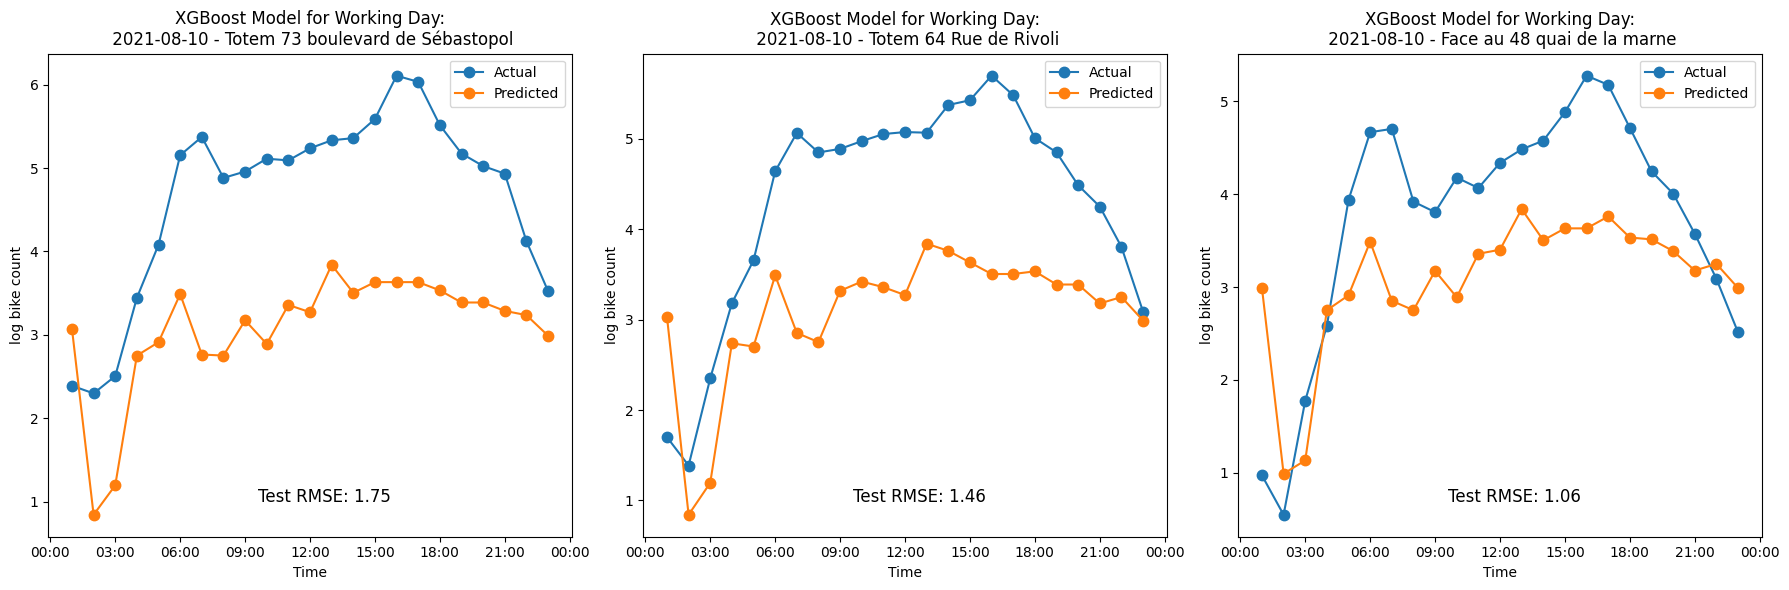

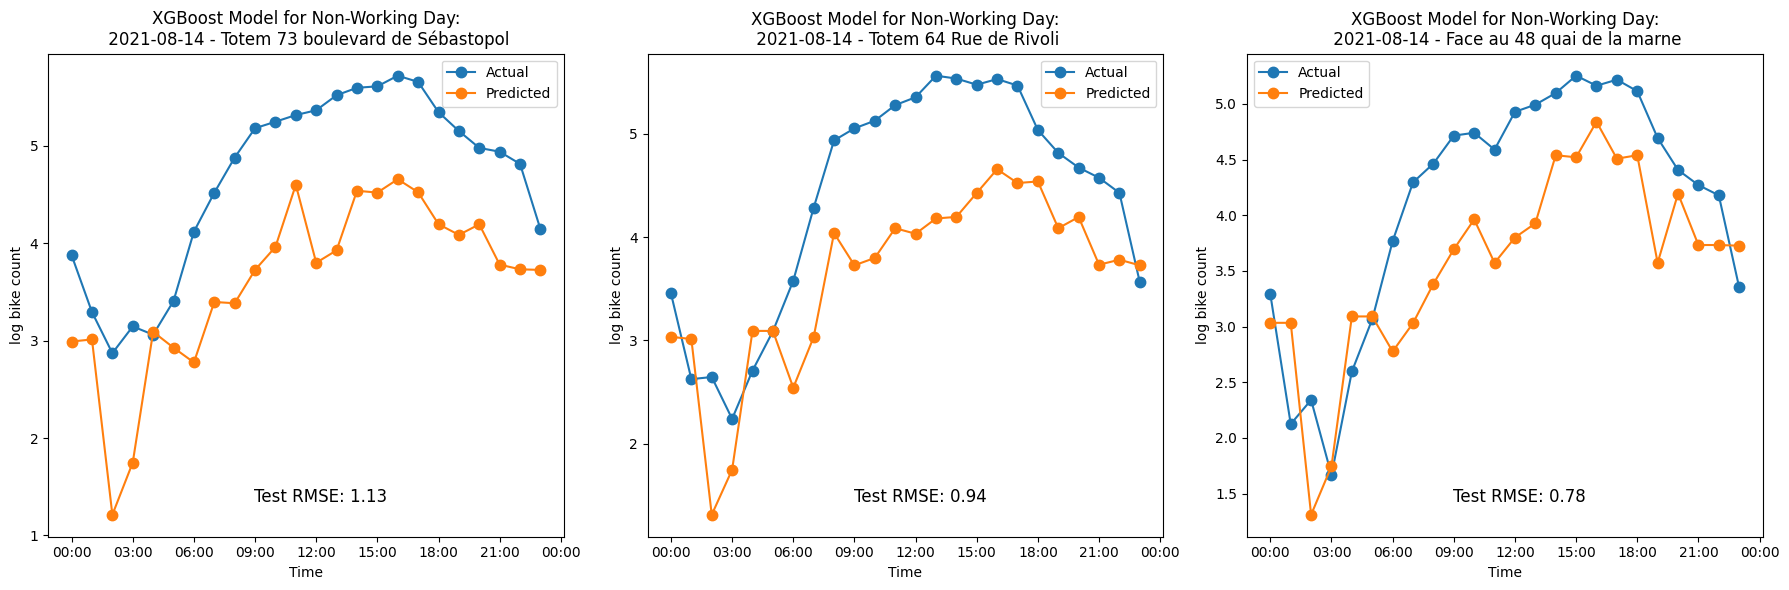

In [23]:
# Set up the multi indexing to get the bike count at a specific site, at a specific time
y_test_w_viz = test_processed_w[["site_name", "log_bike_count"]]
y_test_w_viz.set_index(['site_name', y_test_w.index], inplace=True)
y_test_w_viz.index.names = ['site_name', 'timestamp']

y_test_nw_viz = test_processed_nw[["site_name", "log_bike_count"]]
y_test_nw_viz.set_index(['site_name', y_test_nw.index], inplace=True)
y_test_nw_viz.index.names = ['site_name', 'timestamp']

# Plot the true bike counts vs our prediction using the given machine learning model on a given working or non-working day given sites
plot_true_vs_pred_workday(y_test_w_viz, y_test_w_pred, 'XGBoost', '2021-08-10', top_sites)
plot_true_vs_pred_non_workday(y_test_nw_viz, y_test_nw_pred, 'XGBoost', '2021-08-14', top_sites)

## Conclusion and Preliminary Selection

In conclusion, our journey into implementing a simple machine learning model for bike count predictions has provided valuable insights into the predictive capabilities of various algorithms. Through visual comparison, we observe that we tend to underestimate the bike counts, especially during working days. It is evident that there is room for improvement in reducing the Root Mean Squared Error (RMSE) to enhance the accuracy of our predictions.

One key observation is the potential for further optimization through hyperparameter tuning. This process involves fine-tuning the configuration of our models to achieve better performance. Although the initial results were promising, the pursuit of higher accuracy and efficiency motivates us to delve into hyperparameter tuning to unlock the full potential of our machine learning models.

Among the models explore, we have identified 4 models, namely XGBoost, RandomForest, Catboost, and LGBM (Light Gradient Boosting Machine), as the top performers even with default parameters. These models exhibited superior predictive capabilities compared to others in our analysis. Our future focus will be dedicated to the refinement and enhancement of these four models through careful hyperparameter tuning.

By concentrating our efforts on these models, we aim to achieve a more robust and accurate prediction of bike counts. This strategic approach will streamline our optimization process, allowing us to channel our resources effectively and maximize the impact of our machine learning implementation. Through continued experimentation and iterative refinement, we anticipate achieving even better results and contributing to the advancement of our predictive modeling for bike count scenarios.